# Building a Spam Email Classifier

In [189]:
# import the desired packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**1. Load the .csv files into Python data frames and the .txt files into lists.**

In [154]:
# Loading the four csv files provided as datframes
df_train = pd.read_csv('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 2/training.csv', 
                        encoding='latin-1')
df_validation = pd.read_csv('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 2/validation.csv',
                           encoding='latin-1')
df_test1 = pd.read_csv('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 2/test1.csv',
                      encoding='latin-1')
df_test2 = pd.read_csv('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 2/test2.csv',
                      encoding='latin-1')

# Loading the two txt files by opening them in read mode and splitting them into lists
list_1 = open('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 2/censored_list_test1.txt').read().split()
list_2 = open('/Users/macbookpro/Desktop/Machine Learning/Assignments/Assignment 2/censored_list_test2.txt').read().split()

**2. Pre-process the SMS messages: Remove all punctuation and numbers from the SMS messages, and change all messages to lower case.**

In [155]:
# Next we will create a function that preprocess the SMS message
import string

def preprocess_SMS(data):
    
    messages = data.loc[:, ['sms']]
    labels = data.loc[:, ['label']]
    
    cleaned_SMS = []
    numbers = '0123456789'
    
    for message in messages.values.ravel():
        message = message.lower()
        for word in message:
            if word in string.punctuation:
                message = message.replace(word, '')
            if word in numbers:
                message = message.replace(word, '')
        cleaned_SMS.append(message)
        
    df = pd.DataFrame(list(zip(labels.values.ravel(), cleaned_SMS)), columns =['label','sms']) 
    
    return df

In [157]:
df_train_clean = preprocess_SMS(df_train)
df_validation_clean = preprocess_SMS(df_validation)
df_test1_clean = preprocess_SMS(df_test1)
df_test2_clean = preprocess_SMS(df_test2)
df_train_clean.head()

,label,sms
0,ham,just sent again do you scream and moan in bed ...
1,ham,when i have stuff to sell ill tell you
2,ham,ugh fuck it im resubbing to eve
3,ham,change windows logoff sound
4,ham,itåäìýìás ì´å£ to get in is that ok


**4. Explain the code: What is the purpose of each function? What do ’train’ and ‘train2’ do, and what is the difference between them? Where in the code is Bayes’ Theorem being applied?**

Before explaining the purpose of each function, it is important to note that when defining a new object in a class (like the NaiveBayesForSpam), any variable that involves "self" are unique to the object defined and held in memory to be specific to the object. By using the “self” keyword we can access the attributes and methods of the class that binds the attributes with the given arguments. 

The first method of the NaiveBayesForSpam class is the "train" function. This function consists of splitting the messages from both the ham and spam category (that are inputted in the function) into words and join them in one large set that will contain the unique words that appeared in all the messages provided. The function will then hold the prior probabilities of both categories in a 2-elements array by calculating the number of messages from each categories over the total number of messages (i.e. number of spam/total number of messages and number of ham/total number of messages). The next step consists of calculating the likelihood of each words and append them in the likelihood list. This is done by iterating through each words gathered in the previous set and calculate for each the likelihood of being in a spam or ham message. The likelihood of a word being spam is done by dividing the number of spam messages containing the word in question by the total number of spam messages and the likelihood of a word being ham is done by dividing the number of ham messages containing the word in question by the total number of ham messages. Note that a minimum of "1" is added to every entry (known as the Laplace estimator) so that if there is no messages from one category containing a specific word, it will not be assigned a probability of zero but rather a probability of 1/length(category messages). This addition of 1 will avoid some potential error in the algorithm. Once the likelihood of each word being in each category is calculated only the minimum between each and 0.95 are appended to the likelihood list. In fact, lets suppose that a word is present in all the messages of the spam category, instead of being assigned a probability of 1 (100%) or higher than 0.95 it will be assigned a probability of 0.95 to avoid any error in the algorithm. Note that the likelihood of each word being spam or ham are added as a list in the likelihood list. The last transformation made in the train function, once the probabilities of all the words are generated, is to build the transpose of the final likelihood list that will thus contain the likelihood of each word being ham in the first row and the likelihood of each word being spam in the second row.

The second method of the NaiveBayesForSpam class is the "train2" function. This function is very similar to the "train" function explained above such that the same steops are followed. In fact, the set containing all the words from all the messages is generated, the prior probabilities of each categories are also calculated and inputted in the prior array, and the likelihood of every word being spam or ham are calculated the same way as stated in the "train" function. However, a new empty list (spamkeywords) is created in the current function and is introduced after finding the likelihoods of each word. In fact, once the likelihood are found an extra step is added here, stating that the likelihood probabilities are added if and only if the likelihood of a word being in a spam message is 20 times higher than the likelihood of this word being in a ham message. Otherwise, it will not be appended. If the condition is satisfied, the minimum value between each likelihood of a word and 0.95 are added to the list and the word in question is also appended to the new list "spamkeywords". Once the function looped through all the words, the words set is reset and assigned the spamkeywords build previously. In fact, these list now contain the words that have a likelihood of being in a spam message that is 20 times higher than its likelihood of being in a ham message. Finally, the likelihoods list is transformed into a transposed matrix.

The third function is the predict function, and requires one message as an input that the function will classify. The main purpose of this function is to calculate the posterior probabilities of one message inputted to define their category. First, a variable named posteriors is attributed a copy of the prior probabilities previously assigned to the object. The function loops through all the words present in the self.word attribute (that are the trained words that are assigned a likelihood probability) previously calculated to the object depending of the function ran (train or train2). By looping through the trained words, the function checks if any of these trained words are present in the message inputted. If the word is located, we multiply the posterior probability (being originally equal to the prior probability) by the likelihood probabilities of this word. In fact, we transformed the likelihood list into a 2 row matrix (first row likelihood of ham, second row likelihood of spam where their index depend on the order they were added). Multiplying the 2-element posterior probability by likelihood[:,i] where i is the index of the word present in both message and our likelihood list mean that we are multiplying both rows at one index i and hence multiplying the posterior of being ham by the likelihood of being ham and the posterior of being spam by the likelihood of being spam. The same process is done for each word located in both the message and the likelihood list. On the other hand, when iterating through the words we have in our training set, if one of the words is not in the unclassified message, the posterior probabilities are multiplied by one minus the likelihood of having this word in each category respectively. Once the posterior probabilities of the unclassified message have been completely updated (after looping through all the words of our training set), we will normalise the posterior probabilities. Finally, if the posterior probability of message being ham is majority (more than 0.5), the message is classified as ham, else, the message is classified as spam.

The last function in the NaiveBayesForSpam class is the score function and requires unlabelled messages and their category as two different inputs. The aim of this function is to provide the accuracy of a Naives Bayes model as well as a confusion matrix that displays the number of correctly labeled messages and falsly labelled messages fo reach category. The steps followed by the function are as follows: First, the messages and their labels are zipped into an iterator that we can access using m and l (looping through the zipped lists allow the function to manipulate a message and its corresponding label). For each message, we will compare the predicted label of the message by calling the predict function and the true label of the message. If the predicted and true label are ham, one is added to the first row first column (true negative), if the predicted is ham and true label is spam, one is added to the first row second column (false negative). If the predicted is spam and true label is ham, one is added to the second row first column (false positive) and if the predicted and true label are spam, one is added to the second row second column (true positive). Looping through all the messages of the zipped list will update the confusion matrix until we obtain the final version. In addition to the confusion matrix, the function will return the estimation misclassification rate equivalent to the number of correctly predicted labels (true neg and true pos) divided by the total number of messages predicted.

In [184]:
class NaiveBayesForSpam:
    def train (self, hamMessages, spamMessages):
        # split every message into words and join them all into a set
        self.words = set(' '.join(hamMessages + spamMessages).split())
        self.priors = np.zeros (2) # create an array of two zeros
        
        # the first element of the array is assigned the prior probability of having a ham message
        self.priors[0] = float (len (hamMessages)) / (len (hamMessages) + len (spamMessages))
        
        # the second element of the array is assigned the prior probability of having a ham message
        self.priors[1] = 1.0 - self.priors[0]
        
        self.likelihoods = [] # create a new empty list that will contain likelihoods
        for i, w in enumerate (self.words): # enumerate the set of words and the index of each
            
            # number of ham messages containing a word / total number of ham messages (likelihood of this word)
            prob1 = (1.0 + len ([m for m in hamMessages if w in m])) / len (hamMessages)
            
            # number of spam messages containing a word / total number of spam messages (likelihood of this word)
            prob2 = (1.0 + len ([m for m in spamMessages if w in m])) / len (spamMessages)
            
            # append to the likelihood list a list containing the likelihood of each word being ham or spam
            self.likelihoods.append ([min (prob1, 0.95), min (prob2, 0.95)])
            
        # likelihoods list transformed into transposed matrix    
        self.likelihoods = np.array(self.likelihoods).T
        
        
    def train2 (self, hamMessages, spamMessages):
        # split every message into words and join them all into a set
        self.words = set (' '.join (hamMessages + spamMessages).split())
        self.priors = np.zeros (2)# create an array of two zeros
        
        # the first element of the array is assigned the prior probability of having a ham message
        self.priors[0] = float (len (hamMessages)) / (len (hamMessages) + len (spamMessages))
        
        # the second element of the array is assigned the prior probability of having a ham message
        self.priors[1] = 1.0 - self.priors[0]
        
        self.likelihoods = [] # create a new empty list that will contain likelihoods
        spamkeywords = [] # create a new empty list that will contain spamkeywords
        for i, w in enumerate (self.words): # enumerate the set of words and the index of each
            
            # number of ham messages containing a word / total number of ham messages (likelihood of this word)
            prob1 = (1.0 + len ([m for m in hamMessages if w in m])) / len (hamMessages)
            
            # number of spam messages containing a word / total number of spam messages (likelihood of this word)
            prob2 = (1.0 + len ([m for m in spamMessages if w in m])) / len (spamMessages)
            
            # if likelihood of word in spam is 20x higher than likelihood of word in ham
            if prob1 * 20 < prob2:
                
                # append to the likelihood list a list containing the likelihood of each word being ham or spam
                self.likelihoods.append ([min (prob1, 0.95), min (prob2, 0.95)])
                
                # append the word in question to the spamkeywords list
                spamkeywords.append (w)
        
        # replace words set with spamkeywords list
        self.words = spamkeywords
        
        # likelihoods list transformed into transposed matrix   
        self.likelihoods = np.array(self.likelihoods).T

        
    def predict (self, message):
        # intialise the posterior probability as a copy of the prior probability
        posteriors = np.copy (self.priors)
        
        for i, w in enumerate (self.words): # enumerate the set of words and the index of each
            if w in message.lower():  # if the word is located in message
                
                # multiply the posterior probability by the likelihood of the located word
                posteriors *= self.likelihoods[:,i]
                
            else: # if the word is not located in message  
                
                # multiply the posterior probability by one minus the likelihood of the located word
                posteriors *= np.ones (2) - self.likelihoods[:,i]
                
            posteriors = posteriors / np.linalg.norm (posteriors)  # normalise
            
        if posteriors[0] > 0.5: # if posterior probability of message being ham is majority 
            return ['ham', posteriors[0]] # classify message as ham
        return ['spam', posteriors[1]] # classify message as spam

    
    def score (self, messages, labels):
        # initialise confusion matrix as a 2x2 square matrix
        confusion = np.zeros(4).reshape (2,2)
        
        for m, l in zip (messages, labels): # iterate through each message and its corresponding label
            
            # call the predict function to predict the label of each message
            if self.predict(m)[0] == 'ham' and l == 'ham': # if predicted and true label are ham
                confusion[0,0] += 1 # add one to the first row first column (true negative)
                
            elif self.predict(m)[0] == 'ham' and l == 'spam': # if predicted is ham and true label is spam
                confusion[0,1] += 1 # add one to the first row second column (false negative)
                
            elif self.predict(m)[0] == 'spam' and l == 'ham': # if predicted is spam and true label is ham
                confusion[1,0] += 1 # add one to the second row first column (false positive)
                
            elif self.predict(m)[0] == 'spam' and l == 'spam': # if predicted and true label are spam 
                confusion[1,1] += 1 # add one to the second row second column (true positive)
                
        # The part below was added to style the confusion matrix and make it easier to analysise
        "----------------------------------------------------------------------------"
        names = ['True Negative','False Positive','False Negative','True Positive']
        counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
        labels = [f"{x}\n{y}" for x, y in zip(names,counts)]
        labels = np.asarray(labels).reshape(2,2)
        "----------------------------------------------------------------------------"
        
        # return the estimation misclassification rate and the confusion matrix
        return (confusion[0,0] + confusion[1,1]) / float (confusion.sum()), sns.heatmap(confusion, cbar = False, 
                annot=labels, fmt = '', cmap='Reds', xticklabels = ['ham', 'spam'],
            yticklabels = ['ham', 'spam'])

**5. Use your training set to train the classifiers ‘train’ and ‘train2’. Note that the interfaces of our classifiers require you to pass the ham and spam messages separately.**

**6. Using the validation set, explore how each of the two classifiers performs out of sample.**

In [151]:
# We will now separate the ham and spam messages of the training sample
hamMessages = []
spamMessages = []
for index, row in df_train_clean.iterrows():
    if row['label'] == 'ham':
        hamMessages.append(row['sms'])
    if row['label'] == 'spam':
        spamMessages.append(row['sms'])

In [159]:
# First splitting the SMS messages into X and y (i.e. into messages and labels)
# validation set
X_validation = df_validation_clean.loc[:, ['sms']]
y_validation = df_validation_clean.loc[:, ['label']]

# test set 1
X_test1 = df_test1_clean.loc[:, ['sms']]
y_test1 = df_test1_clean.loc[:, ['label']]

# test set 2
X_test2 = df_test2_clean.loc[:, ['sms']]
y_test2 = df_test2_clean.loc[:, ['label']]

CPU times: user 55.4 s, sys: 522 ms, total: 55.9 s
Wall time: 55.5 s


(0.9621802002224694, <AxesSubplot:>)

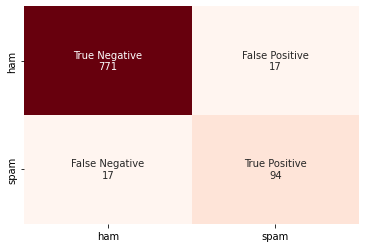

In [185]:
%%time
NaiveBayes1 = NaiveBayesForSpam()
NaiveBayes1.train(hamMessages, spamMessages)
prediction1 = NaiveBayes1.score(X_validation.values.ravel(), y_validation.values.ravel())
prediction1

CPU times: user 2.68 s, sys: 6.92 ms, total: 2.69 s
Wall time: 2.69 s


(0.9621802002224694, <AxesSubplot:>)

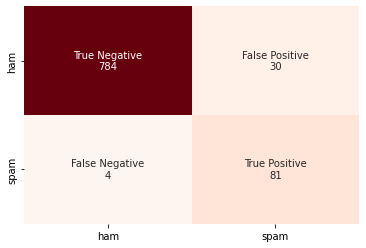

In [186]:
%%time
NaiveBayes2 = NaiveBayesForSpam()
NaiveBayes2.train2(hamMessages, spamMessages)
prediction2 = NaiveBayes2.score(X_validation.values.ravel(), y_validation.values.ravel())
prediction2

**7. Why is the ‘train2’ classifier faster? Why does it yield a better accuracy both on the training and the validation set?**

**8. How many false positives (ham messages classified as spam messages) did you get in your validation set? How would you change the code to reduce false positives at the expense of possibly having more false negatives (spam messages classified as ham messages)?**

The second row of the first column of the confusion matrix holds the false positives, i.e. the messages that have been classified as spam while their true label are ham. Using the train function to train our model, we obtained 17 false positives and using the train2 function we obtained 4 false positives. In the case where the class of interest is false positives, meaning that we want the classifier to reduce the number of ham message wrongly classified as spam (especially for email classifiers where ham emails could be important work email), a normal classifier would not be the best. One idea is to oversample the messages of interest such that the number of available messages labeled as ham would be higher than the spam messages. However, the tradeoff of this method is that the classifier will probably do worse at classifying spam messages as ham messages (false negatives).

We could apply the stratified sampling algorithm to our code where our class of interest would be the ham category. As we can see from the histogram below, our training set is clearly unbalanced. The stratified sampling algorithm would generate a training data set by taking 50% of the messages categorised as ham from the whole dataset and 50% of the messages classified as spam. Then, for the validation set, we would select the remaining 50% of ham messages and add enough spam messages to restore the original ratio from the overall data set. 

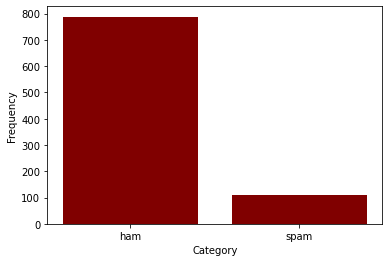

In [201]:
data = df_train_clean['label'].value_counts()
plt.bar(['ham','spam'], [data[0], data[1]], color ='maroon')
 
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.show()

**9. Assuming the missing words are (Xj = xj,...,Xk = xk) with k ≤ p, how would you change the formula given as hint to calculate P(Y = Cj | X1 = x1,...,Xp = xp)?**

Having removed 10% and 30% of the trained words from the test sets, we cannot assume their presence in these sets, meaning that we cannot add to the posterior probability the likelihood of the censored words being or not in the message. In fact, the predict function loops through the trained words and try to locate them in the message, located or not the posterior probability is updated depending on their likelihood. Since the censored words have been removed from the test set we cannot assume that the words that are both trained and censored are located or not in the message. Hence, the formula should be changed such that all the words that are censored does not change the posterior probability in any way and would be considered as unknown. An easy way to make up for the missing words would be to only consider the training words that are not in the censored list, depending on the chosen censored list.

**10. Modify the ‘predict’ function in the code to implement the change in the previous point, and use it to report accuracies on test1, with both ‘train’ and ‘train2’.**

In [209]:
class NaiveBayesForSpam_censored:
    def train (self, hamMessages, spamMessages):
        # split every message into words and join them all into a set
        self.words = set(' '.join(hamMessages + spamMessages).split())
        self.priors = np.zeros (2) # create an array of two zeros
        
        # the first element of the array is assigned the prior probability of having a ham message
        self.priors[0] = float (len (hamMessages)) / (len (hamMessages) + len (spamMessages))
        
        # the second element of the array is assigned the prior probability of having a ham message
        self.priors[1] = 1.0 - self.priors[0]
        
        self.likelihoods = [] # create a new empty list that will contain likelihoods
        for i, w in enumerate (self.words): # enumerate the set of words and the index of each
            
            # number of ham messages containing a word / total number of ham messages (likelihood of this word)
            prob1 = (1.0 + len ([m for m in hamMessages if w in m])) / len (hamMessages)
            
            # number of spam messages containing a word / total number of spam messages (likelihood of this word)
            prob2 = (1.0 + len ([m for m in spamMessages if w in m])) / len (spamMessages)
            
            # append to the likelihood list a list containing the likelihood of each word being ham or spam
            self.likelihoods.append ([min (prob1, 0.95), min (prob2, 0.95)])
            
        # likelihoods list transformed into transposed matrix    
        self.likelihoods = np.array(self.likelihoods).T
        
        
    def train2 (self, hamMessages, spamMessages):
        # split every message into words and join them all into a set
        self.words = set (' '.join (hamMessages + spamMessages).split())
        self.priors = np.zeros (2)# create an array of two zeros
        
        # the first element of the array is assigned the prior probability of having a ham message
        self.priors[0] = float (len (hamMessages)) / (len (hamMessages) + len (spamMessages))
        
        # the second element of the array is assigned the prior probability of having a ham message
        self.priors[1] = 1.0 - self.priors[0]
        
        self.likelihoods = [] # create a new empty list that will contain likelihoods
        spamkeywords = [] # create a new empty list that will contain spamkeywords
        for i, w in enumerate (self.words): # enumerate the set of words and the index of each
            
            # number of ham messages containing a word / total number of ham messages (likelihood of this word)
            prob1 = (1.0 + len ([m for m in hamMessages if w in m])) / len (hamMessages)
            
            # number of spam messages containing a word / total number of spam messages (likelihood of this word)
            prob2 = (1.0 + len ([m for m in spamMessages if w in m])) / len (spamMessages)
            
            # if likelihood of word in spam is 20x higher than likelihood of word in ham
            if prob1 * 20 < prob2:
                
                # append to the likelihood list a list containing the likelihood of each word being ham or spam
                self.likelihoods.append ([min (prob1, 0.95), min (prob2, 0.95)])
                
                # append the word in question to the spamkeywords list
                spamkeywords.append (w)
        
        # replace words set with spamkeywords list
        self.words = spamkeywords
        
        # likelihoods list transformed into transposed matrix   
        self.likelihoods = np.array(self.likelihoods).T

        
    def predict (self, message, censored_list):
        # intialise the posterior probability as a copy of the prior probability
        posteriors = np.copy (self.priors)
        
        for i, w in enumerate (self.words): # enumerate the set of words and the index of each
            # if the word is located in message and not located in censored list
            if w in message.lower() and w not in censored_list:  
                
                # multiply the posterior probability by the likelihood of the located word
                posteriors *= self.likelihoods[:,i]
            
            # if the word is not located in both message and censored list
            elif w not in message.lower() and w not in censored_list: 
                
                # multiply the posterior probability by one minus the likelihood of the located word
                posteriors *= np.ones (2) - self.likelihoods[:,i]
                
            posteriors = posteriors / np.linalg.norm (posteriors)  # normalise
            
        if posteriors[0] > 0.5: # if posterior probability of message being ham is majority 
            return ['ham', posteriors[0]] # classify message as ham
        return ['spam', posteriors[1]] # classify message as spam

    
    def score (self, messages, labels, censored_list):
        # initialise confusion matrix as a 2x2 square matrix
        confusion = np.zeros(4).reshape (2,2)
        
        for m, l in zip (messages, labels): # iterate through each message and its corresponding label
            
            # call the predict function to predict the label of each message
            if self.predict(m, censored_list)[0] == 'ham' and l == 'ham': # if predicted and true label are ham
                confusion[0,0] += 1 # add one to the first row first column (true negative)
                
            elif self.predict(m, censored_list)[0] == 'ham' and l == 'spam': # if predicted is ham and true label is spam
                confusion[0,1] += 1 # add one to the first row second column (false negative)
                
            elif self.predict(m, censored_list)[0] == 'spam' and l == 'ham': # if predicted is spam and true label is ham
                confusion[1,0] += 1 # add one to the second row first column (false positive)
                
            elif self.predict(m, censored_list)[0] == 'spam' and l == 'spam': # if predicted and true label are spam 
                confusion[1,1] += 1 # add one to the second row second column (true positive)
                
        # The part below was added to style the confusion matrix and make it easier to analysise
        "----------------------------------------------------------------------------"
        names = ['True Negative','False Positive','False Negative','True Positive']
        counts = ["{0:0.0f}".format(value) for value in confusion.flatten()]
        labels = [f"{x}\n{y}" for x, y in zip(names,counts)]
        labels = np.asarray(labels).reshape(2,2)
        "----------------------------------------------------------------------------"
        
        # return the estimation misclassification rate and the confusion matrix
        return (confusion[0,0] + confusion[1,1]) / float (confusion.sum()), sns.heatmap(confusion, cbar = False, 
                annot=labels, fmt = '', cmap='Reds', xticklabels = ['ham', 'spam'],
            yticklabels = ['ham', 'spam'])

In [210]:
censored_list = list_1 + list_2

### Test 1

(0.9758566978193146, <AxesSubplot:>)

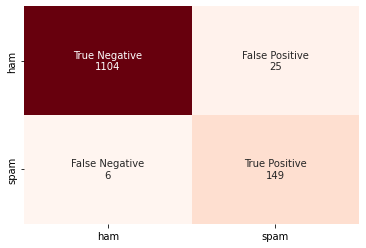

In [213]:
NaiveBayes1_censored = NaiveBayesForSpam_censored()
NaiveBayes1_censored.train(hamMessages, spamMessages)
prediction1_cencored = NaiveBayes1_censored.score(X_test1.values.ravel(), y_test1.values.ravel(), censored_list)
prediction1_cencored

(0.9672897196261683, <AxesSubplot:>)

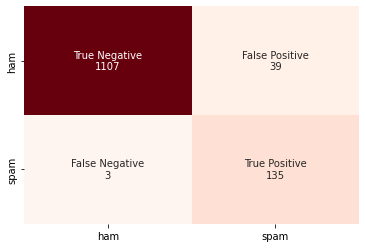

In [212]:
NaiveBayes2_censored = NaiveBayesForSpam_censored()
NaiveBayes2_censored.train2(hamMessages, spamMessages)
prediction2_cencored = NaiveBayes2_censored.score(X_test1.values.ravel(), y_test1.values.ravel(), censored_list)
prediction2_cencored

### Test 2

(0.9603421461897356, <AxesSubplot:>)

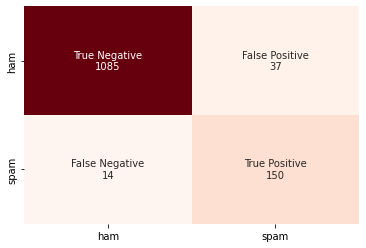

In [215]:
NaiveBayes3_censored = NaiveBayesForSpam_censored()
NaiveBayes3_censored.train(hamMessages, spamMessages)
prediction3_cencored = NaiveBayes3_censored.score(X_test2.values.ravel(), y_test2.values.ravel(), censored_list)
prediction3_cencored

(0.9595645412130638, <AxesSubplot:>)

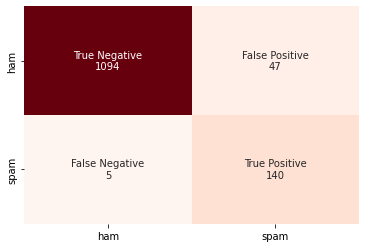

In [214]:
NaiveBayes4_censored = NaiveBayesForSpam_censored()
NaiveBayes4_censored.train2(hamMessages, spamMessages)
prediction4_cencored = NaiveBayes4_censored.score(X_test2.values.ravel(), y_test2.values.ravel(), censored_list)
prediction4_cencored